In [1]:
import torch
from torch import nn
from torchinfo import summary
import matplotlib.pylab as plt
from torchvision import transforms

from modules import data_setup, engine, utils

In [2]:
data_path = utils.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")
test_dir = data_path / "test"
train_dir = data_path / "train"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# From the paper we get that the training resolution is 224 and the batch size is 4096
# We will stick to 32 as having a batch size of 4096 means that 4096 images need to fit into the GPU memory at a time
IMG_SIZE = 224
BATCH_SIZE = 32

# There is no need to normalize are we aren't transfer learning but training the model from scratch
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    manual_transform,
    BATCH_SIZE
)

torch.Size([3, 224, 224]) tensor(1)


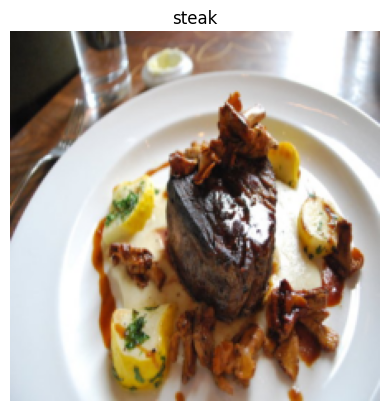

In [3]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(image.shape, label)

# Add semicolon (;) to suppress the output
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

Details about the model are sprinkled across the paper, we will mainly look at Figure 1, Section 3.1 and Table 1

![Figure1](img/Figure1.png)

Differents stages of the architecture:
1) **Patch + Position Embedding:** the image is turn into patches and encodes a position number to specify the patches order
2) **Linear Projection of Flattened Patches:** the patches are turn into an embedding, meaning represented as a vector of numbers, so that the model can learn them
3) **Transformer Encoder**: there are two skip connections ("+" symbols) meaning the layer's output is fed to the immediate layer as well as subsequent layers. For L times:
    1) **Norm:** this is short of Layer Normalization, a technique for regularizing (reducing overfitting of) a neural network
    2) **Multi-Head Attention:** this is a Multi-Headed Self-Attention layer, or MSA for short
    3) **Norm**
    4) **MLP**: short for Multilayer perceptron, is a collection of layers with a forward() method. In this case:
        1) Linear layer
        2) GELU non-linearity activation
        3) Dropout
        3) Linear layer
        4) Dropout layer
4) **MLP Head**: it has a similar structure as the MLP block, it is the classifier of this network as it converts the learned features to a class output

Also later we can see: "Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings". Dropout is to be added when dealing with small datasets to avoid overfitting, they ofter avoid using it with very big datasets, hence "when used"

![Section3.1](img/Section3.1.png)

**Equation (1)**<br>
The transformer has a latent (hidden) dimension of D, so every token will be a vector of dimension D. Here we take x1, x2, x3, ..., that are N patches of dimensions P^2xC, where N = HW/P^2.
Then they are multiplied by a learnable matrix E of dimension (P^2xC)xD that flattens them, so what results is a vector of length N with each token of length D. They follow learnable [class] token of length D. At last, learnable position embeddings of dimensions (N+1)xD are added to mantain positional data.

**Equations (2) and (3)**<br>
The transformers has L layers, in every layer z(l-1) passes through a NormLayer, then a MSA layer, with a skip connection represented by the final addition, becoming z'l. Then through a NormLayer, then a MLP layer with another skip connection, becoming zl.

**Equation (4)**<br>
After the transformer, the 0 index token of his output zL goes through a NormLayer. The position 0 contains the [clas] token, whose job is to sum up the data contained in the rest of the vector. Therefore it's the only index looked at to decide the final class output.

![Table1](img/Table1.png)

This table showcases the hyperparameters of each of the ViT architectures. We will replicate ViT-Base as a start. The Hyperparameters are:
1) Layers: the number of layers in the transformer architecture
2) Hidden size D: the latent dimension of every token inside the N+1 long vector that goes through the ViT. The bigger, the more information can be captured
3) MLP size: the number of hidden units in the MLP layer
4) Heads: the number of heads in the MSA layer
5) Params: the number of trainable parameteres in the architecture

Dropout probability for ViT-Base is 0.1

In [4]:
H, W = 224, 224
C = 3

# Table 5 says that the ViT-B/16 is the best performing model
P = 16
N = int((H*W)/P**2)

D = 768

In [5]:
# (1, 224, 224, 3)
conv2d = nn.Conv2d(
    in_channels=C,
    out_channels=D,
    kernel_size=P,
    stride=P,
    padding=0
)
# (1, 768, 14, 14)
flatten = nn.Flatten(
    start_dim=2,
    end_dim=3
)
# (1, 768, 196)
# .permute(0, 2, 1)
# (1, 196, 768)
# Adding the class token
# (1, 197, 768)

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=768):
        super().__init__()

        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )

    def forward(self, x: torch.Tensor):
        return self.flatten(self.patcher(x)).permute(0, 2, 1)

In [7]:
patchify = PatchEmbedding(3, 16, 768)
print(f"Input shape: {image.unsqueeze(0).shape}")
print(f"Output shape: {patchify(image.unsqueeze(0)).shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])


In [8]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, dropout: float=0):
        super().__init__()

        self.norm_layer = nn.LayerNorm(
            normalized_shape=embedding_dim
        )

        self.MSA_layer = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, x: torch.Tensor):
        x = self.norm_layer(x)
        attn_output, _ = self.MSA_layer(
            query=x,
            key=x,
            value=x,
            need_weights=False
        )
        return attn_output

In [9]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: float=0.1):
        super().__init__()

        self.norm_layer = nn.LayerNorm(
            normalized_shape=embedding_dim
        )

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x: torch.Tensor):
        return self.mlp(self.norm_layer(x))

In [10]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_heads: int=12, embedding_dim: int=768, attn_dropout: float=0, mlp_size: int=3072, mlp_dropout: float=0.1):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim, mlp_size, mlp_dropout)
        
    def forward(self, x: torch.Tensor):
        x = self.msa_block(x) + x
        return self.mlp_block(x) + x

In [11]:
transformer = TransformerEncoderBlock()
summary(
    model=transformer,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (MSA_layer)              --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [12]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [13]:
torch_tranformer_encoder = nn.TransformerEncoder(torch_transformer_encoder_layer, num_layers=12)
summary(
    model=torch_tranformer_encoder,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

/home/glauco/Desktop/projects/learningPyTorch/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─ModuleList (layers)                              --                   --                   --                   True
│    └─TransformerEncoderLayer (0)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (norm1)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    │    └─MultiheadAttention (self_attn)         [1, 197, 768]        [1, 197, 768]        2,362,368            True
│    │    └─Dropout (dropout1)                     [1, 197, 768]        [1, 197, 768]        --                   --
│    │    └─LayerNorm (norm2)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    │    └─Linear (linear1)                 

In [14]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: float=0,
                 mlp_dropout: float=0.1,
                 embedding_dropout: float=0.1,
                 num_classes: int=1000):
        super().__init__()

        assert img_size % patch_size == 0, "Image size must be divisible by patch size!"
        self.num_patches = (img_size * img_size) // patch_size**2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout, mlp_size=mlp_size, mlp_dropout=mlp_dropout) 
              for _ in range(num_transformer_layers)]
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = x + self.position_embedding
        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        
        return x

In [15]:

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
print(vit(random_image_tensor))
summary(
    model=vit,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

tensor([[-0.1300, -0.0782, -1.1411]], grad_fn=<AddmmBackward0>)


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

In [16]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4317 | train_acc: 0.2891 | test_loss: 1.4527 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.4283 | train_acc: 0.4375 | test_loss: 1.8178 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1640 | train_acc: 0.4492 | test_loss: 1.7269 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1794 | train_acc: 0.3711 | test_loss: 1.4256 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1526 | train_acc: 0.4219 | test_loss: 1.0824 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2234 | train_acc: 0.2930 | test_loss: 1.5470 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2526 | train_acc: 0.2891 | test_loss: 1.0598 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1861 | train_acc: 0.2500 | test_loss: 1.0302 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.1706 | train_acc: 0.4062 | test_loss: 1.3470 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2107 | train_acc: 0.3008 | test_loss: 1.1382 | test_acc: 0.1979
